In [1]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, float64, complex128, int64, types, objmode

from matplotlib.patches import Circle


from collections import namedtuple as nt
mode_params=nt("mode_params", "a0 m p Mp w0")

from scipy.special import hermite, genlaguerre

%matplotlib inline

In [2]:
@jit(types.Tuple((complex128[:,:,:], 
                  float64[:,:,:], 
                  int64, 
                  int64))
     (int64, 
      int64, 
      float64, 
      float64, 
      float64, 
      float64, 
      float64[:,:,:], 
      float64[:,:,:], 
      float64[:,:,:]), cache=True, nopython=True, parallel=True)
def LG_mode_accelerated(mode_params_m, 
                        mode_params_p, 
                        mode_params_Mp, 
                        mode_params_w0, 
                        mode_params_a0, tau, r, phi, z):
    a0 = mode_params_a0
    m = mode_params_m  # mode number x
    p = mode_params_p  # mode number y
    Mp = mode_params_Mp
    w0 = mode_params_w0
    
    #Lpm=genlaguerre(p,np.abs(m))

    ZR = Mp*w0**2/2
    ZR_sq = np.square(ZR)
    r_sq = np.square(r)
    z_sq = np.square(z)
    
    w = w0*np.sqrt(1+z_sq/ZR_sq)
    w_sq = np.square(w)
    chi = np.arctan(z/ZR)
    
    
    #toret = 1/np.sqrt(w)*(r*np.sqrt(2)/w)**np.abs(m)
    toret = (r*np.sqrt(2)/w)**np.abs(m)

    exp_factor = np.exp(-1j*r_sq*z/2/(ZR_sq+z_sq) + 1j*m*phi -z_sq/2/tau**2 + \
                        1j*Mp*z -1j*(2*p+np.abs(m)+1)*chi-r_sq/w_sq)
    toret = toret * exp_factor
    
    return a0*toret, 2*r_sq/w_sq, p, m

In [37]:
class LG_mode_generation():
    
    """
        This class features the suport of LG modes generation and reflected field analysis.
        After fitting, the following results are stored in corresponding member variables:
            self.zmirror - describes the motion of target
            self.refl_field - interpolated field generated after LG_mode interaction with target
            self.fft_result - FFT transform of the reflected field
            self.fft_freq - set of corresponding frequencies in FFT
    """
    
    def __init__(self, params_dict):
        
        self.fitted = False
        self.mode_params = []
        self.mode_params.append(mode_params(*params_dict["mode_0"])) ###mode_params
        self.mode_params.append(mode_params(*params_dict["mode_1"])) ###mode_params
        self.coord_type = params_dict["coords"]["type"]
        
        self.tau = params_dict["tau"]
        self.delay = params_dict["delay"]
        
        if self.coord_type == "cartesian":
            xmin = params_dict["coords"]["xmin"]#-10
            xmax = params_dict["coords"]["xmax"]#10
            ymin = params_dict["coords"]["ymin"]#-10
            ymax = params_dict["coords"]["ymax"]#10
            zmin = params_dict["coords"]["zmin"]#-15
            zmax = params_dict["coords"]["zmax"]#15
            
            nofxs = params_dict["discretization"]["x"]#60
            nofys = params_dict["discretization"]["y"]#60
            nofzs = params_dict["discretization"]["z"]#2400
            
            self.zmin, self.zmax = zmin, zmax
            
            xx = np.linspace(xmin*2*np.pi, xmax*2*np.pi, nofxs)
            yy = np.linspace(ymin*2*np.pi, ymax*2*np.pi, nofys)
            zz = np.linspace(zmin*2*np.pi, zmax*2*np.pi, nofzs)
            self.d_sampling_rate = zz[1] - zz[0]
            self.nofzs = nofzs
            self.x,self.y,self.z = np.meshgrid(xx,yy,zz, indexing='xy')
        elif (self.coord_type == "polar"):
            zmin = params_dict["coords"]["zmin"]#-15
            zmax = params_dict["coords"]["zmax"]#15
            nofzs = params_dict["discretization"]["z"]#2400
            zz = np.linspace(zmin*2*np.pi, zmax*2*np.pi, nofzs)
            self.d_sampling_rate = zz[1] - zz[0]
            rhos = np.linspace(0, 7*2*np.pi, 20)
            phis = np.linspace(0, 2*np.pi, 150)
            
            self.zmin, self.zmax = zmin, zmax
            
            self.r,self.phi,self.z = np.meshgrid(rhos,phis,zz, indexing='xy')
        else:
            raise ValueError("Unsupported coordinate type!\
            Supported values are [\'cartesian\', \'polar\']")
    @staticmethod
    def calculate_spectrum(field, d_rate):
        fft_res = np.fft.fft(field, axis=2)
        fft_freq = np.fft.fftfreq(len(field[1,1,:]), d=d_rate)
        return fft_res, fft_freq
        
    @staticmethod
    def LG_mode(mode_params, tau, r, phi, z):
        mode, arg, p,m = LG_mode_accelerated(mode_params.m, 
                                         mode_params.p, 
                                         mode_params.Mp, 
                                         mode_params.w0, 
                                         mode_params.a0, tau, r, phi, z)
        Lpm = genlaguerre(p, np.abs(m))
        mode = mode * Lpm(arg)
        return mode
    
    @staticmethod
    def get_interp_field(z, zd, refl_field):
        refl_field_interp = np.zeros_like(refl_field)
        for i in range(z.shape[0]):
            for j in range(z.shape[1]):
                refl_field_interp[i,j,:] = np.interp(z[i,j,:], zd[i,j,:], refl_field[i,j,:])
        return refl_field_interp
    
    def coords_polar(self):
        if self.coord_type =="polar":
            return self.r, self.phi
        else:
            r = np.sqrt(self.x**2+self.y**2)

            xiy = self.x + 1j*self.y
            phi = np.angle(xiy)
            return r, phi
        
    def calculate_field(self):
        r, phi = self.coords_polar()
        start = datetime.now()
        print("Calculating LG modes...", end="")
        LG_mode_1 = self.LG_mode(self.mode_params[0], self.tau, r, phi, self.z-self.delay/2)
        field_x = np.abs(LG_mode_1) * np.cos(np.angle(LG_mode_1))

        LG_mode_2 = self.LG_mode(self.mode_params[1], self.tau, r, phi, self.z+self.delay/2)
        field_x = field_x + np.abs(LG_mode_2) * np.cos(np.angle(LG_mode_2))
        
        print("OK!")
        
        envelope1 = np.abs(LG_mode_1)
        envelope2 = np.abs(LG_mode_2)
        
        print("Calculating reflected fields...", end="")
        full_envelope = np.sqrt(envelope1**2 + \
                            envelope2**2 + 2*envelope1*envelope2*\
                            np.cos(np.angle(LG_mode_2)-np.angle(LG_mode_1)))

        zmirror = 1./(1+full_envelope ** 2)*(envelope1*np.cos(np.angle(LG_mode_1))+\
                                                 envelope2*np.cos(np.angle(LG_mode_2)))**2

        refl_field = envelope1 * np.cos(np.angle(self.LG_mode(self.mode_params[0], 
                                                              self.tau, r, phi, self.z-self.delay/2+zmirror)))
        refl_field = refl_field + envelope2 * np.cos(np.angle(self.LG_mode(self.mode_params[1],
                                                              self.tau, r, phi, self.z+self.delay/2+zmirror)))

        zd = self.z-zmirror
        
        self.incident_field = field_x
        self.zmirror = zmirror
        self.full_envelope = full_envelope
        self.refl_field = self.get_interp_field(self.z, zd, refl_field)
        print("OK!")
        print("Calculating field spectrum...", end="")
        self.fft_result, self.fft_freq = self.calculate_spectrum(self.refl_field, 
                                                                 self.d_sampling_rate)
        self.fitted = True
        print(f"OK!\nFinished training in {(datetime.now()-start).total_seconds()} seconds.")
        return True
    def count_spectrogram(self, r, n_harmonics=3):
        dz = self.d_sampling_rate/(2*np.pi)      # in wavelength

        window_width = 2.0   # in wavelengths
        dtau_window = 0.1    # in wavelengths
        nofzs_window = (self.zmax - self.zmin)/dtau_window

        omegas = np.fft.fftfreq(self.refl_field.shape[2], d=dz)

        idx = np.argwhere(np.abs(np.abs(omegas)-n_harmonics)<1e-2)[0][0] #3rd harmonics idx

        print("Counting spectrogram...")
        spectrogram = np.zeros((self.refl_field.shape[0], int(nofzs_window), 1), 
                               dtype=np.complex128)
        for phi in range(self.refl_field.shape[0]):
            field = self.refl_field[phi,r,:]
            #sp=np.fft.fft(field)
            specgram_phi = None
            flag = False
            for n in np.arange(nofzs_window):
                window_pos = self.zmin+n * dtau_window
                window_func = np.exp(-(self.z[phi, r,:]/2/np.pi - window_pos)**100/window_width**100)
                y = field * window_func
                sp = np.fft.fft(y)
                if flag == False:
                    specgram = sp[idx]
                    flag = True
                else:
                    specgram = np.vstack([specgram, sp[idx]])
            spectrogram[phi, :, :] = specgram
            #specgram_global[r, phi] = specgram 
        #self.specgram = specgram_global
        return spectrogram
    def plot_incident_field(self, ):
        pass
    def calculate_radial_spectrum(self, rho):
        r, phi = self.coords_polar()
        try:
            field_slice = self.incident_field[:,rho, :]
        except:
            print(f"Invalid rho value ({rho})!")
            return
        radial_spectrum = np.fft.fft(field_slice, axis=1)
        frequencies = np.fft.fftfreq(self.nofzs, self.d_sampling_rate)
        return radial_spectrum, frequencies

In [38]:
params_dict = {
    "mode_0" : [3., 1, 0, 1., 3.**2*np.pi],
    "mode_1" : [3., 2, 0, 1., 3.**2*np.pi],
    "coords" :
        {
            "type": "cartesian",
            "xmin": -10,
            "xmax": 10,
            "ymin": -10,
            "ymax": 10,
            "zmin": -15,
            "zmax": 15
        },
    "tau": 4*2*np.pi,
    "delay": -2*4*2*np.pi,
    "discretization": {
                        "x": 60,
                        "y": 60,
                        "z": 2400
    }
               }

In [39]:
params_dict = {
    "mode_0" : [3., 1, 0, 1., 3.**2*np.pi],
    "mode_1" : [3., 2, 0, 1., 3.**2*np.pi],
    "coords" :
        {
            "type": "polar",
            "zmin": -15,
            "zmax": 15
        },
    "tau": 4*2*np.pi,
    "delay": -2*4*2*np.pi,
    "discretization": {
            
                        "z": 2400
    }
               }

In [40]:
lg_mode = LG_mode_generation(params_dict)

In [41]:
lg_mode.calculate_field()

Calculating LG modes...OK!
Calculating reflected fields...OK!
Calculating field spectrum...OK!
Finished training in 4.561374 seconds.


True

In [42]:
lg_mode.refl_field.shape

(150, 20, 2400)

In [43]:
spectrogram = lg_mode.count_spectrogram(r=10)

Counting spectrogram...


In [44]:
spectrogram.shape

(150, 300, 1)

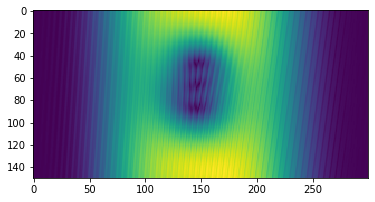

In [45]:
plt.imshow(np.abs(spectrogram[:,:,0]))

In [ ]:
zmin = params_dict["coords"]["zmin"]
zmax = params_dict["coords"]["zmax"]
nofzs = params_dict["discretization"]["z"]
z = np.linspace(zmin*2*np.pi, zmax*2*np.pi, nofzs)

plt.plot(z/2/np.pi, field)

In [ ]:
dz = lg_mode.d_sampling_rate/(2*np.pi)      # in wavelength

window_width = 2.0   # in wavelengths
dtau_window = 0.1    # in wavelengths
nofzs_window = (zmax - zmin)/dtau_window


omegas = np.fft.fftfreq(lg_mode.refl_field.shape[2], d = dz)

idx = np.argwhere(np.abs(np.abs(omegas)-3)<1e-2)[0][0] #3rd harmonics idx

for r in range(lg_mode.refl_field.shape[0]):
    print(r)
    for phi in range(lg_mode.refl_field.shape[1]):
        field = lg_mode.refl_field[r,phi,:]
        sp=np.fft.fft(field)
        specgram_global = np.zeros((lg_mode.refl_field.shape[0],
                                    lg_mode.refl_field.shape[0] , 300,1), dtype=np.complex128)
        flag = False
        for n in np.arange(nofzs_window):
            window_pos = zmin+n * dtau_window
            window_func = np.exp(-(z/2/np.pi - window_pos)**100/window_width**100)
            y = field * window_func
            sp = np.fft.fft(y)

            # index 3rd harmonic
            # for example sp[10] corresponds to 3rd harmonic
            # r,phi, angle(sp[10])

            if flag == False:
                specgram = sp[idx]
                flag = True
            else:
                specgram = np.vstack([specgram, sp[idx]])
        #print(specgram.shape)
        specgram_global[r, phi] = specgram 

In [ ]:
plt.imshow(np.abs(specgram.T), aspect='auto')

In [ ]:
omegas = np.fft.fftfreq(lg_mode.refl_field.shape[2], d = dz)
@jit((complex128[:,:,:,:](float64[:,:,:],float64, float64, float64, float64[:])), cache=True, parallel=True)
def calculate_specgram(refl_field, dz, zmin, zmax, omegas):
    #dz = lg_mode.d_sampling_rate/(2*np.pi)      # in wavelength

    window_width = 2.0   # in wavelengths
    dtau_window = 0.1    # in wavelengths
    nofzs_window = (zmax - zmin)/dtau_window

    flag = False

    
    idx = np.argwhere(np.abs(np.abs(omegas)-3)<1e-2)[0][0] #3rd harmonics idx
    for r in range(refl_field.shape[0]):
        print(r)
        for phi in range(refl_field.shape[1]):
            field = refl_field[r,phi,:]
            sp=np.fft.fft(field)
            for n in np.arange(nofzs_window):
                window_pos = zmin+n * dtau_window
                window_func = np.exp(-(z/2/np.pi - window_pos)**100/window_width**100)
                y = field * window_func
                with objmode(out='complex128[:,:]'):
                    sp = np.fft.fft(y)

                # index 3rd harmonic
                # for example sp[10] corresponds to 3rd harmonic
                # r,phi, angle(sp[10])

                if flag == False:
                    specgram = sp[idx]
                    flag = True
                else:
                    specgram = np.vstack([specgram, sp[idx]])

In [ ]:
calculate_specgram(lg_mode.refl_field,dz,zmin, zmax, omegas)

In [ ]:
nrows = 2306
ncols = 95
Z = np.abs(spectrogram_result)
print(Z.shape)
x = np.arange(ncols + 1)
y = np.arange(nrows + 1)


plt.pcolormesh(x, y, Z,)

In [ ]:
spectrogram_result.shape == Z.shape

In [ ]:
y.shape

In [ ]:
Z.shape